In [4]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.9 MB/s eta 0:00:001m24.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import rasterio
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import sobel
from sklearn.decomposition import PCA



In [11]:

# Directories for data
rainfall_dir = r"/home/stormej/dev/varsha/data/rain/rain_resampled_monthly"
ndvi_dir = r"/home/stormej/dev/varsha/data/ndvi/ndvi_resampled_monthly"
lst_dir = r"/home/stormej/dev/varsha/data/lst/lst_composite_delhi_monthly_resampled"
dem_path = r"/home/stormej/dev/varsha/data/dem/dem_resampled.tif"

start_year = 2000
end_year = 2022

In [18]:
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Paths to directories
lst_dir = r"D:\lst_monthly_8_day_test"
ndvi_dir = r"D:\lst_monthly_8_day_test"
masked_ndvi_dir = r"D:\lst_monthly_8_day_test_masked"  # Directory to save masked NDVI data
os.makedirs(masked_ndvi_dir, exist_ok=True)

# Get an LST file to create a land mask
lst_files = sorted(os.listdir(lst_dir))
lst_file = lst_files[0]  # Use the first LST file as the mask reference

# Load LST data and create a land mask
with rasterio.open(os.path.join(lst_dir, lst_file)) as lst_src:
    lst_data = lst_src.read(1)
    # Create mask where True represents land (LST != -9999)
    land_mask = (lst_data != -9999).astype(np.uint8)
    lst_transform = lst_src.transform
    lst_crs = lst_src.crs

# Apply the land mask on NDVI data
for ndvi_file in sorted(os.listdir(ndvi_dir)):
    ndvi_path = os.path.join(ndvi_dir, ndvi_file)
    with rasterio.open(ndvi_path) as ndvi_src:
        # Read NDVI data
        ndvi_data = ndvi_src.read(1)
        
        # Check if the dimensions match
        if ndvi_data.shape != lst_data.shape:
            # Resample the land mask to match the NDVI data
            transform, width, height = calculate_default_transform(
                lst_crs, ndvi_src.crs, 
                lst_data.shape[1], lst_data.shape[0], 
                *lst_src.bounds
            )
            resampled_mask = np.empty((height, width), dtype=np.uint8)
            reproject(
                source=land_mask,
                destination=resampled_mask,
                src_transform=lst_transform,
                src_crs=lst_crs,
                dst_transform=transform,
                dst_crs=ndvi_src.crs,
                resampling=Resampling.nearest
            )
            mask_to_apply = resampled_mask
        else:
            mask_to_apply = land_mask

        # Apply the mask (set ocean values to NaN in NDVI data)
        ndvi_data[mask_to_apply == 0] = np.nan

        # Save the masked NDVI data
        output_path = os.path.join(masked_ndvi_dir, ndvi_file)
        meta = ndvi_src.meta.copy()
        meta.update(dtype=rasterio.float32, nodata=np.nan)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(ndvi_data, 1)

print("Masked NDVI files saved to:", masked_ndvi_dir)

Masked NDVI files saved to: D:\lst_monthly_8_day_test_masked


In [4]:

# Get the list of files

rainfall_files = sorted(os.listdir(rainfall_dir))
ndvi_files = sorted(os.listdir(ndvi_dir))
lst_files = sorted(os.listdir(lst_dir))

# We'll load DEM data after we know the correct shape from rainfall data
dem_flat = None
shape = None

# Function to extract date from filenames for each file type
def extract_date_from_filename(filename, prefix, date_format):
    date_str = filename.replace(prefix, '').replace('.tif', '')
    return datetime.strptime(date_str, date_format)

data_collection = []
dates = []
spatial_reference = None

# First, get the correct shape from a rainfall file
with rasterio.open(os.path.join(rainfall_dir, rainfall_files[0])) as src:
    shape = src.shape
    spatial_reference = src.crs

# Now load and reshape DEM data
with rasterio.open(dem_path) as src:
    # Read and resample DEM data to match rainfall data shape if necessary
    dem_data = src.read(
        1,
        out_shape=shape,
        resampling=rasterio.enums.Resampling.bilinear
    )
    dem_flat = dem_data.flatten()

# Process and load data
for rf in tqdm(rainfall_files, desc="Processing files"):
    try:
        rf_date = extract_date_from_filename(rf, 'IMD_Rainfall_Monthly_Sum_', '%Y_%m_%B')
        
        if not (start_year <= rf_date.year <= end_year):
            continue
        
        matching_ndvi = next((nf for nf in ndvi_files if extract_date_from_filename(nf, 'MODIS_NDVI_Monthly_', '%Y_%m_%B') == rf_date), None)
        matching_lst = next((lf for lf in lst_files if extract_date_from_filename(lf, 'lst_monthly_mean_', '%Y-%m') == rf_date), None)
        
        if matching_ndvi and matching_lst:
            # Load rainfall data
            with rasterio.open(os.path.join(rainfall_dir, rf)) as src:
                rainfall_data = src.read(1)
                rainfall_flat = rainfall_data.flatten()
                
                # Get coordinates for each pixel
                coords = np.array([src.xy(row, col) for row in range(shape[0]) for col in range(shape[1])])
                latitudes, longitudes = coords[:, 1], coords[:, 0]
            
            # Load NDVI data
            with rasterio.open(os.path.join(ndvi_dir, matching_ndvi)) as src:
                if src.crs != spatial_reference or src.read(1).shape != shape:
                    print(f"Spatial reference or shape mismatch in {matching_ndvi}")
                    continue
                ndvi_flat = src.read(1).flatten()
            
            # Load LST data
            with rasterio.open(os.path.join(lst_dir, matching_lst)) as src:
                if src.crs != spatial_reference or src.read(1).shape != shape:
                    print(f"Spatial reference or shape mismatch in {matching_lst}")
                    continue
                lst_flat = src.read(1).flatten()
            
            # Create feature array with NDVI, LST, DEM, latitude, and longitude
            feature_stack = np.column_stack([ndvi_flat, lst_flat, dem_flat, latitudes, longitudes])
            
            # Store valid data
            mask = ~np.isnan(rainfall_flat) & ~np.isnan(feature_stack).any(axis=1)
            if mask.any():
                data_collection.append({
                    'date': rf_date,
                    'features': feature_stack[mask],
                    'rainfall': rainfall_flat[mask]
                })
                dates.append(rf_date)
    
    except Exception as e:
        print(f"Error processing {rf}: {str(e)}")
        continue

Processing files: 100%|██████████| 96/96 [01:08<00:00,  1.40it/s]


In [5]:

# Rest of the code remains the same...
X = np.vstack([d['features'] for d in data_collection])
y = np.concatenate([d['rainfall'] for d in data_collection])
print(f"Final data shape - X: {X.shape}, y: {y.shape}")

Final data shape - X: (1671840, 5), y: (1671840,)


In [6]:
# Preprocess the data
rainfall_mask = (y >= 0) & (y < np.percentile(y, 99.9))
feature_mask = np.all((X > np.percentile(X, 0.1, axis=0)) & (X < np.percentile(X, 99.9, axis=0)), axis=1)
mask = rainfall_mask & feature_mask
X_cleaned = X[mask]
y_cleaned = y[mask]

In [7]:
# Scale features
scaler = RobustScaler()
X_cleaned = scaler.fit_transform(X_cleaned)

# Split the data (temporal split)
split_idx = int(len(X_cleaned) * 0.8)
X_train, X_test = X_cleaned[:split_idx], X_cleaned[split_idx:]
y_train, y_test = y_cleaned[:split_idx], y_cleaned[split_idx:]

In [8]:

# Define and train Random Forest model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining model...")
model.fit(X_train, y_train)


Training model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=500, n_jobs=-1,
                      random_state=42, verbose=1)

In [9]:

# Model evaluation and visualization code remains the same...
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.9s finished


In [10]:

print(f"\nModel performance on test set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} mm")
print(f"R2 Score: {r2:.4f}")


Model performance on test set:
MSE: 4087.41
RMSE: 63.93 mm
R2 Score: 0.3693


In [11]:

# Feature importance
feature_names = ['NDVI', 'LST', 'DEM', 'Latitude', 'Longitude']
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)

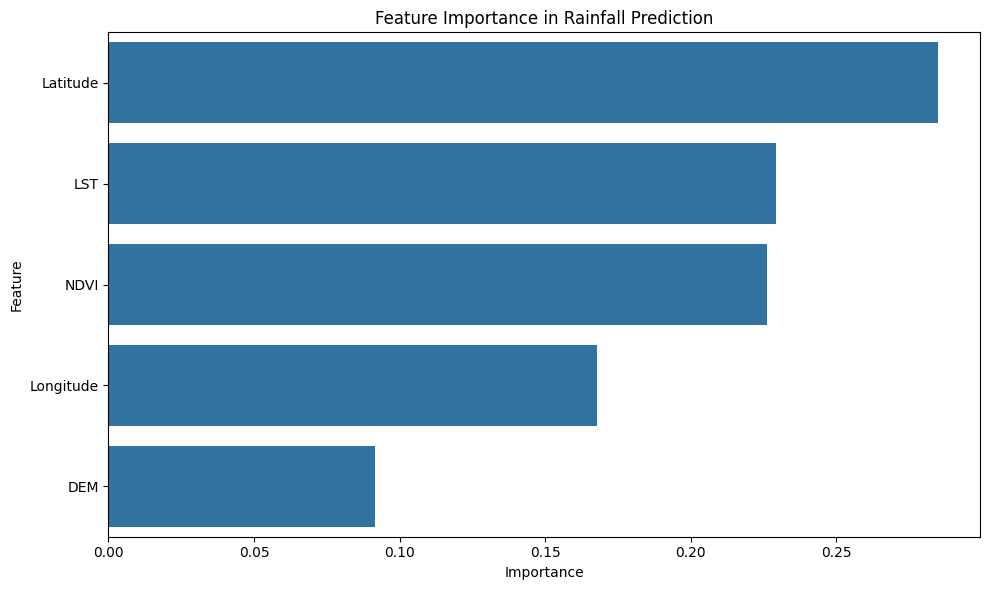

In [12]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Rainfall Prediction')
plt.tight_layout()
plt.show()

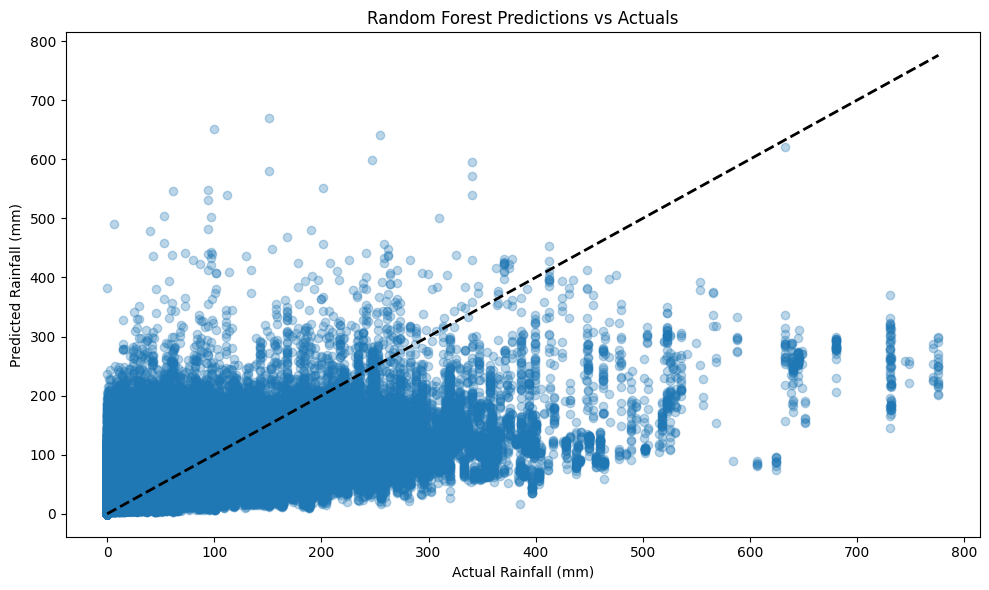

In [13]:
# Analyze prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Random Forest Predictions vs Actuals')
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
from scipy.ndimage import uniform_filter

def calculate_terrain_features(dem_data):
    """Calculate terrain features from DEM"""
    # Calculate slope
    dy, dx = np.gradient(dem_data)
    slope = np.sqrt(dx**2 + dy**2)
    
    # Calculate aspect
    aspect = np.arctan2(dy, dx)
    
    # Calculate terrain roughness (standard deviation of elevation in local window)
    mean_elevation = uniform_filter(dem_data, size=3)
    roughness = uniform_filter((dem_data - mean_elevation)**2, size=3)
    
    # Ensure no negative values before applying square root
    roughness = np.sqrt(np.maximum(roughness, 0))
    
    # Handle any remaining NaNs in slope, aspect, or roughness
    slope = np.nan_to_num(slope, nan=0.0)
    aspect = np.nan_to_num(aspect, nan=0.0)
    roughness = np.nan_to_num(roughness, nan=0.0)
    
    return slope, aspect, roughness


# Directories for data
rainfall_dir = r"D:\imd_monthly_test"
ndvi_dir = r"D:\ndvi_monthly_test"
lst_dir = r"D:\lst_monthly_8_day_test"
dem_path = r"D:\dem_test\merged_dem.tif"  # Add path to your resampled DEM file

start_year = 2010
end_year = 2017

# Get the list of files
rainfall_files = sorted(os.listdir(rainfall_dir))
ndvi_files = sorted(os.listdir(ndvi_dir))
lst_files = sorted(os.listdir(lst_dir))

# First, get the correct shape from a rainfall file
with rasterio.open(os.path.join(rainfall_dir, rainfall_files[0])) as src:
    shape = src.shape
    spatial_reference = src.crs

# Load and process DEM data
with rasterio.open(dem_path) as src:
    dem_data = src.read(
        1,
        out_shape=shape,
        resampling=rasterio.enums.Resampling.bilinear
    )
    
    # Calculate terrain features
    slope, aspect, roughness = calculate_terrain_features(dem_data)
    
    # Flatten all terrain features
    dem_flat = dem_data.flatten()
    slope_flat = slope.flatten()
    aspect_flat = aspect.flatten()
    roughness_flat = roughness.flatten()

# Rest of the data loading code...
data_collection = []
dates = []

for rf in tqdm(rainfall_files, desc="Processing files"):
    try:
        rf_date = extract_date_from_filename(rf, 'IMD_Rainfall_Monthly_Sum_', '%Y_%m_%B')
        
        if not (start_year <= rf_date.year <= end_year):
            continue
        
        matching_ndvi = next((nf for nf in ndvi_files if extract_date_from_filename(nf, 'MODIS_NDVI_Monthly_', '%Y_%m_%B') == rf_date), None)
        matching_lst = next((lf for lf in lst_files if extract_date_from_filename(lf, 'lst_monthly_mean_', '%Y-%m') == rf_date), None)
        
        if matching_ndvi and matching_lst:
            # Load data as before...
            with rasterio.open(os.path.join(rainfall_dir, rf)) as src:
                rainfall_data = src.read(1)
                rainfall_flat = rainfall_data.flatten()
                coords = np.array([src.xy(row, col) for row in range(shape[0]) for col in range(shape[1])])
                latitudes, longitudes = coords[:, 1], coords[:, 0]
            
            with rasterio.open(os.path.join(ndvi_dir, matching_ndvi)) as src:
                ndvi_flat = src.read(1).flatten()
            
            with rasterio.open(os.path.join(lst_dir, matching_lst)) as src:
                lst_flat = src.read(1).flatten()
            
            # Create feature array with all features including terrain features
            feature_stack = np.column_stack([
                ndvi_flat, lst_flat, 
                dem_flat, slope_flat, aspect_flat, roughness_flat,
                latitudes, longitudes
            ])
            
            mask = ~np.isnan(rainfall_flat) & ~np.isnan(feature_stack).any(axis=1)
            if mask.any():
                data_collection.append({
                    'date': rf_date,
                    'features': feature_stack[mask],
                    'rainfall': rainfall_flat[mask]
                })
                dates.append(rf_date)
    
    except Exception as e:
        print(f"Error processing {rf}: {str(e)}")
        continue

Processing files: 100%|██████████| 96/96 [01:06<00:00,  1.44it/s]


In [6]:
# Prepare data
X = np.vstack([d['features'] for d in data_collection])
y = np.concatenate([d['rainfall'] for d in data_collection])
print(f"Final data shape - X: {X.shape}, y: {y.shape}")


Final data shape - X: (1671840, 8), y: (1671840,)


In [7]:
# Clean and scale data
rainfall_mask = (y >= 0) & (y < np.percentile(y, 99.9))
feature_mask = np.all((X > np.percentile(X, 0.1, axis=0)) & (X < np.percentile(X, 99.9, axis=0)), axis=1)
mask = rainfall_mask & feature_mask
X_cleaned = X[mask]
y_cleaned = y[mask]

scaler = RobustScaler()
X_cleaned = scaler.fit_transform(X_cleaned)

In [7]:


pca = PCA(n_components=6)  # Adjust n_components based on explained variance
X_pca = pca.fit_transform(X_cleaned)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Transformed data shape: {X_pca.shape}")

PCA Explained Variance Ratio: [0.6714936  0.101853   0.06418327 0.04736744 0.03943996 0.03277234]
Transformed data shape: (862129, 6)


In [8]:
# Split the data (temporal split)
split_idx = int(len(X_cleaned) * 0.8)
X_train, X_test = X_cleaned[:split_idx], X_cleaned[split_idx:]
y_train, y_test = y_cleaned[:split_idx], y_cleaned[split_idx:]

In [9]:

# Define and train Random Forest model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining model...")
model.fit(X_train, y_train)


Training model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=500, n_jobs=-1,
                      random_state=42, verbose=1)

In [10]:
# Model evaluation and visualization code remains the same...
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel performance on test set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} mm")
print(f"R2 Score: {r2:.4f}")


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s



Model performance on test set:
MSE: 4076.86
RMSE: 63.85 mm
R2 Score: 0.3774


[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.9s finished


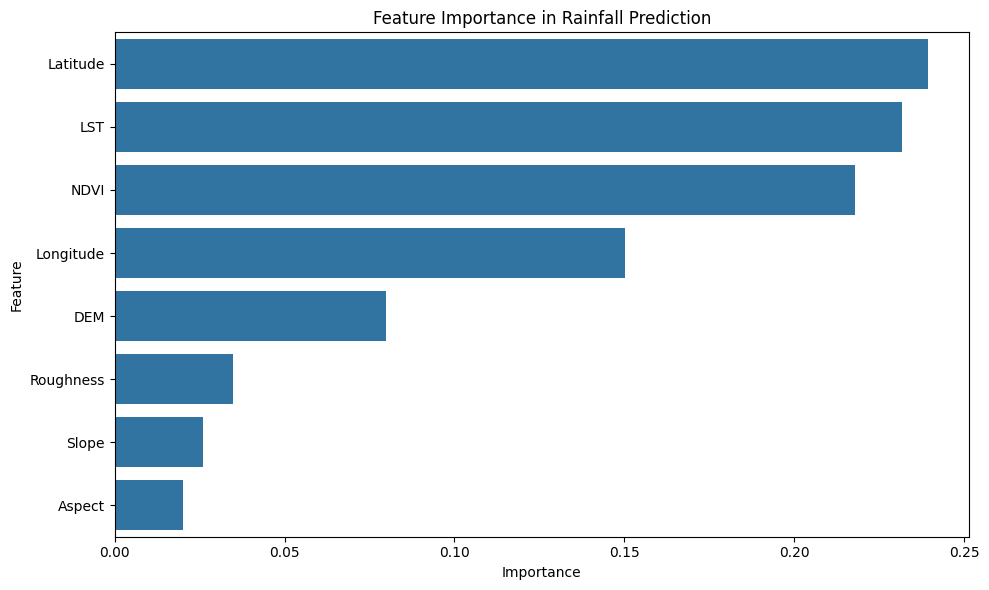

In [12]:
# Train models with different feature sets for comparison
feature_names = ['NDVI', 'LST', 'DEM', 'Slope', 'Aspect', 'Roughness', 'Latitude', 'Longitude']
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Rainfall Prediction')
plt.tight_layout()
plt.show()






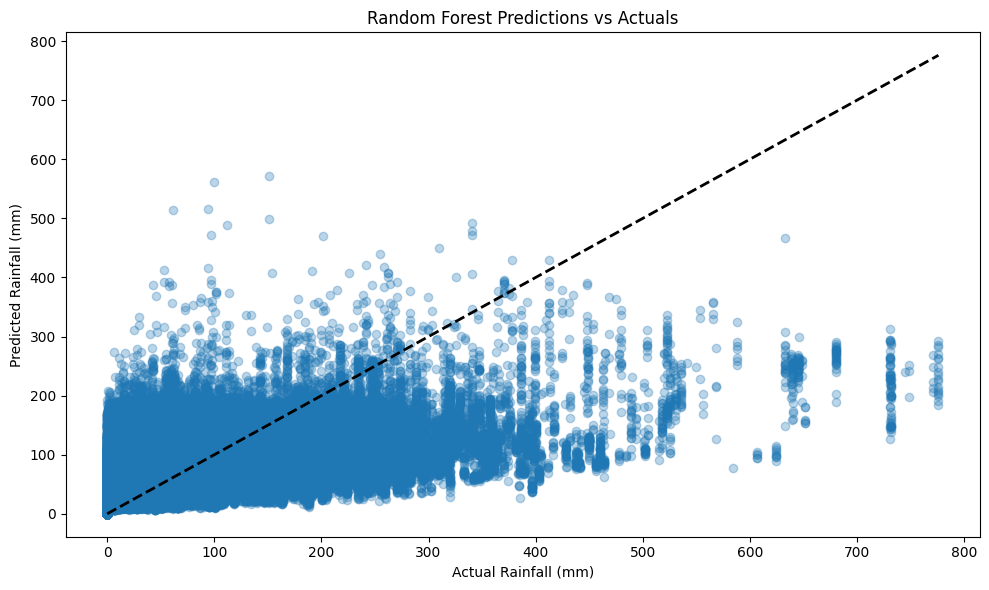

In [13]:
# Analyze prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Random Forest Predictions vs Actuals')
plt.tight_layout()
plt.show()


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 

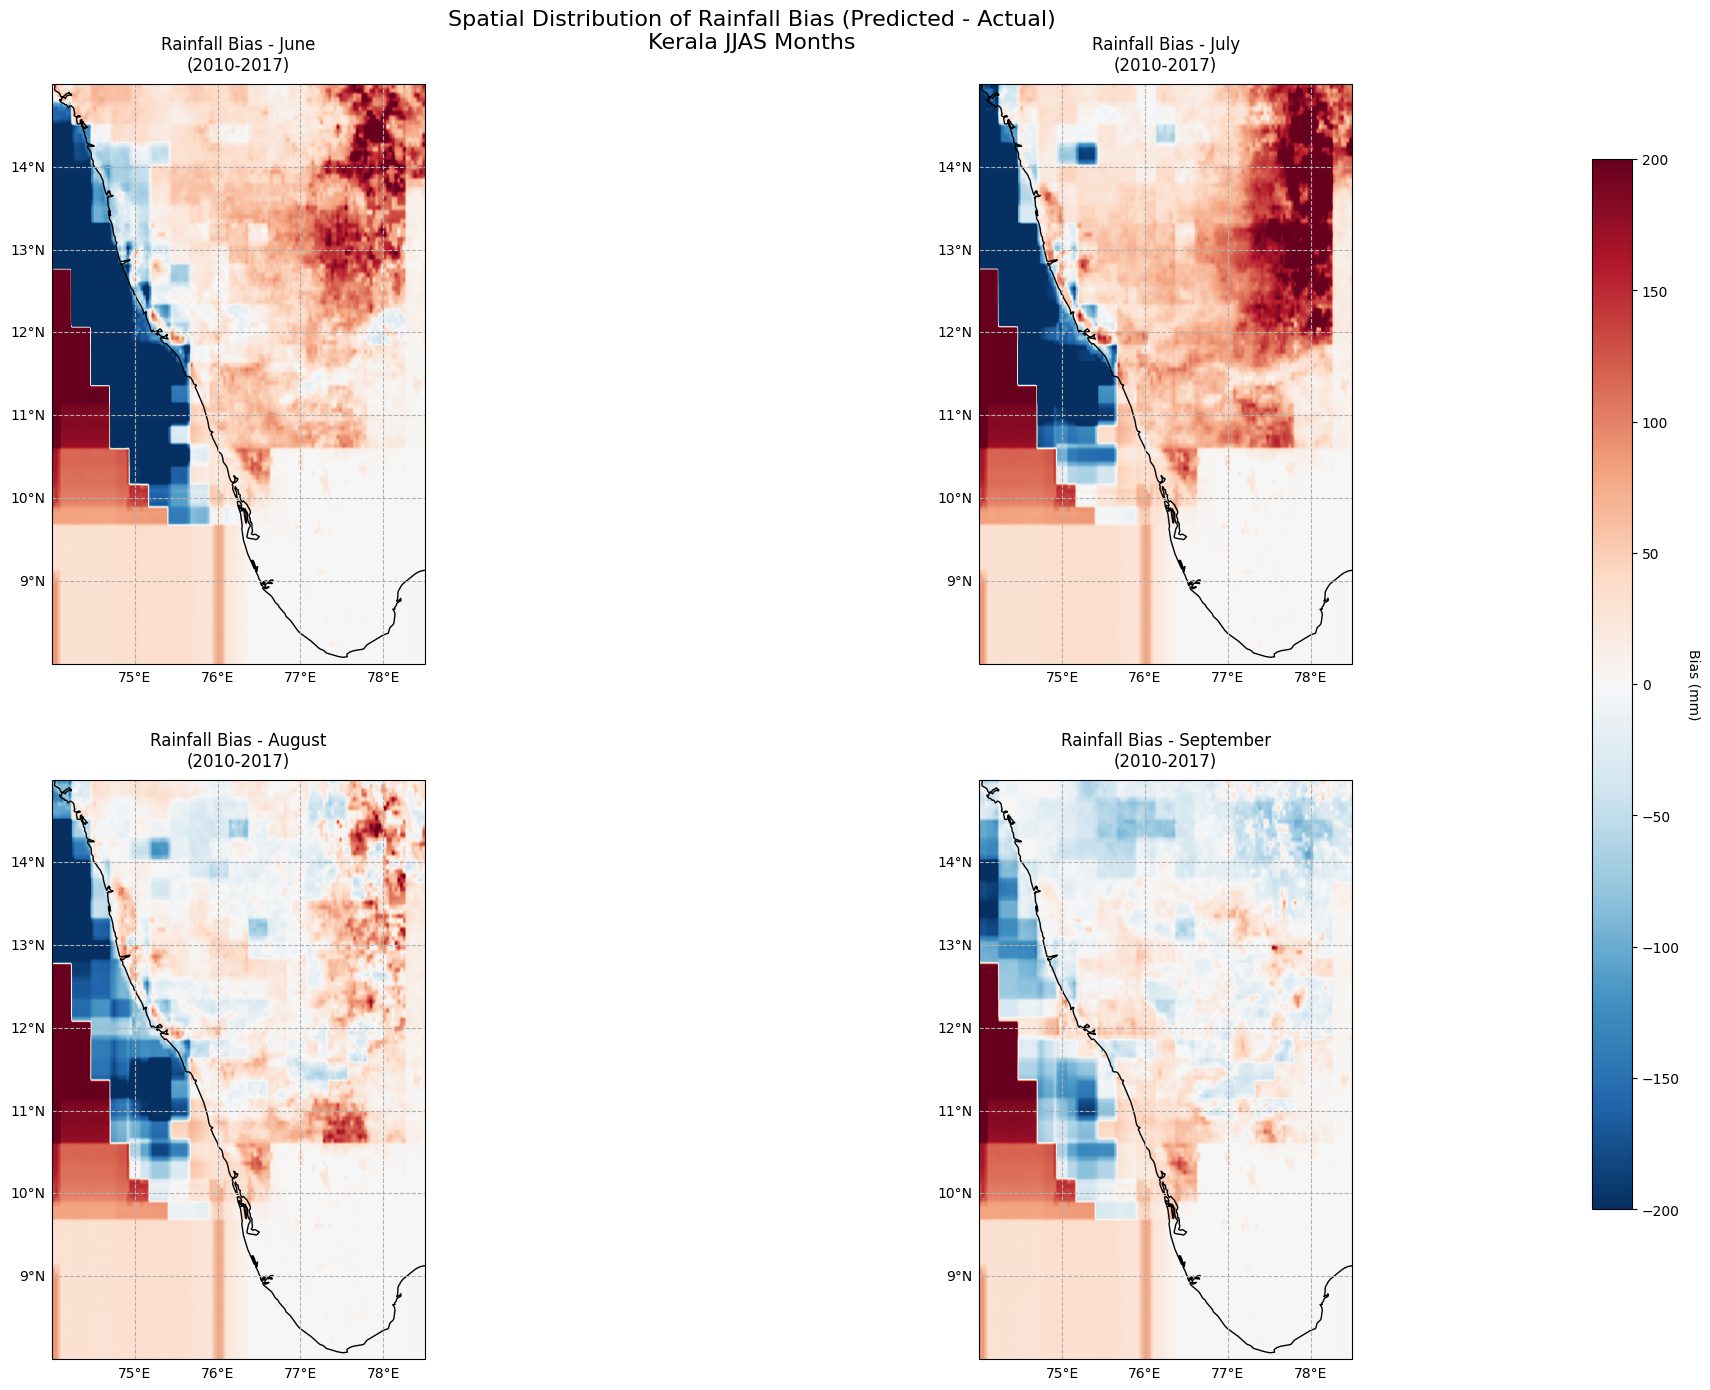

In [14]:
def plot_kerala_spatial_bias(model, data_collection, scaler, shape, dates):
    """
    Create spatial plots of model bias for Kerala during JJAS months
    with limits optimized for Kerala's monsoon rainfall patterns.
    """
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, figure=fig)
    
    # Dictionary to store aggregated bias values
    monthly_bias = {
        6: np.zeros(shape),  # June
        7: np.zeros(shape),  # July
        8: np.zeros(shape),  # August
        9: np.zeros(shape)   # September
    }
    monthly_counts = {month: np.zeros(shape) for month in range(6, 10)}
    
    # Process each timestamp
    for idx, entry in enumerate(data_collection):
        date = entry['date']
        
        # Skip if not JJAS
        if date.month not in [6, 7, 8, 9]:
            continue
            
        # Get features and actual rainfall
        features = entry['features']
        actual_rainfall = entry['rainfall']
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Get predictions
        predicted_rainfall = model.predict(features_scaled)
        
        # Calculate bias
        bias = predicted_rainfall - actual_rainfall
        
        # Create a mask for the current data points
        current_mask = np.zeros(shape).flatten()
        valid_indices = np.where(~np.isnan(entry['rainfall']))[0]
        current_mask[valid_indices] = 1
        current_mask = current_mask.reshape(shape)
        
        # Update monthly aggregations
        bias_grid = np.zeros(shape).flatten()
        bias_grid[valid_indices] = bias
        bias_grid = bias_grid.reshape(shape)
        
        monthly_bias[date.month] += bias_grid
        monthly_counts[date.month] += current_mask
    
    # Calculate average bias for each month
    for month in monthly_bias:
        mask = monthly_counts[month] > 0
        monthly_bias[month][mask] /= monthly_counts[month][mask]
    
    # Create plots
    month_names = {6: 'June', 7: 'July', 8: 'August', 9: 'September'}
    
    # Set up the extent for Kerala
    extent = [74.0, 78.5, 8.0, 15.0]
    
    for idx, month in enumerate(monthly_bias):
        ax = fig.add_subplot(gs[idx//2, idx%2], projection=ccrs.PlateCarree())
        
        # Plot bias with adjusted vmin/vmax
        # Using symmetric limits of ±200 mm based on the scatter plot
        vmin, vmax = -200, 200
        im = ax.imshow(monthly_bias[month], 
                      cmap='RdBu_r',
                      vmin=vmin, 
                      vmax=vmax,
                      extent=extent,
                      transform=ccrs.PlateCarree())
        
        # Add coastlines and borders
        ax.coastlines(resolution='10m')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Add title with month and year range
        ax.set_title(f'Rainfall Bias - {month_names[month]}\n(2010-2017)', pad=10)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Bias (mm)', rotation=270, labelpad=15)
    
    plt.suptitle('Spatial Distribution of Rainfall Bias (Predicted - Actual)\nKerala JJAS Months', 
                 fontsize=16, y=0.95)
    
    # Adjust layout
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.05)
    
    return fig

# Call the function
fig = plot_kerala_spatial_bias(
    model=model,
    data_collection=data_collection,
    scaler=scaler,
    shape=shape,
    dates=dates
)

plt.show()
    
        


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 

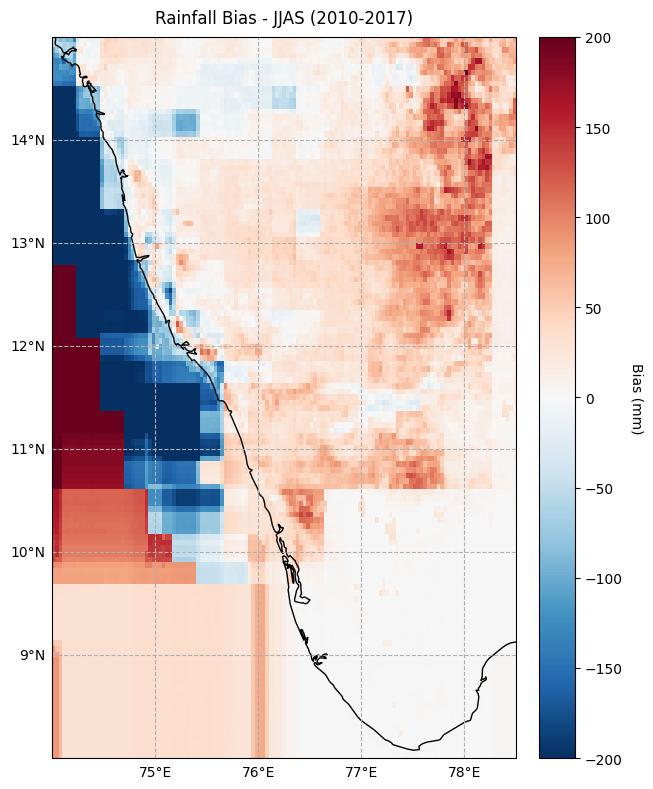

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_jjas_bias(model, data_collection, scaler, shape, output_dir=None):
    """
    Create a single spatial plot of model bias for the JJAS season (June, July, August, September).

    Parameters:
    -----------
    model : RandomForestRegressor
        Trained random forest model.
    data_collection : list
        List of dictionaries containing features and rainfall data.
    scaler : RobustScaler
        Fitted scaler used for feature transformation.
    shape : tuple
        Original spatial shape of the data (height, width).
    output_dir : str, optional
        Directory to save the plot.
    """

    # Initialize arrays for bias calculation
    bias_sum = np.zeros(shape)
    count = np.zeros(shape)

    # Process data for JJAS months
    for entry in data_collection:
        date = entry['date']

        # Only process data for JJAS months (June = 6, July = 7, August = 8, September = 9)
        if date.month not in [6, 7, 8, 9]:
            continue

        # Get features and actual rainfall
        features = entry['features']
        actual_rainfall = entry['rainfall']

        # Scale features and get predictions
        features_scaled = scaler.transform(features)
        predicted_rainfall = model.predict(features_scaled)

        # Calculate bias
        bias = predicted_rainfall - actual_rainfall

        # Create a mask for valid data points
        current_mask = np.zeros(shape).flatten()
        valid_indices = np.where(~np.isnan(actual_rainfall))[0]
        current_mask[valid_indices] = 1
        current_mask = current_mask.reshape(shape)

        # Update bias sum and count
        bias_grid = np.zeros(shape).flatten()
        bias_grid[valid_indices] = bias
        bias_grid = bias_grid.reshape(shape)

        bias_sum += bias_grid
        count += current_mask

    # Calculate average bias for JJAS
    mask = count > 0
    jjas_bias = np.zeros_like(bias_sum)
    jjas_bias[mask] = bias_sum[mask] / count[mask]

    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    # Set up the extent for Kerala
    extent = [74.0, 78.5, 8.0, 15.0]

    # Plot bias
    vmin, vmax = -200, 200  # Adjust these values as needed
    im = ax.imshow(jjas_bias,
                   cmap='RdBu_r',
                   vmin=vmin,
                   vmax=vmax,
                   extent=extent,
                   transform=ccrs.PlateCarree())

    # Add coastlines and borders
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add title
    ax.set_title('Rainfall Bias - JJAS (2010-2017)', pad=10)

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Bias (mm)', rotation=270, labelpad=15)

    # Adjust layout
    plt.tight_layout()

    # Save plot if output directory is provided
    if output_dir:
        plt.savefig(f'{output_dir}/bias_map_jjas.png', bbox_inches='tight', dpi=300)

    return fig

# Generate and show the plot for JJAS season
fig = plot_jjas_bias(
    model=model,
    data_collection=data_collection,
    scaler=scaler,
    shape=shape,
    output_dir=r"D:\spatial_bias_jjas"  # Optional directory to save the plot
)
plt.show()
plt.close()
